In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from copy import deepcopy
import random

IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 200,200

random.seed(42)

RDKit WARNING: [10:54:24] Enabling RDKit 2019.09.1 jupyter extensions


In [2]:
#smi_file='NIST_Si_100.txt'
smi_file='NIST_Si_all.txt'
mols={}
with open(smi_file) as f:
    for smi in f:
        m = Chem.MolFromSmiles(smi)
        if m: mols[smi.rstrip()] = m

In [6]:
SiMe1=Chem.MolFromSmarts('[Si][CH3]')
SiMe2=Chem.MolFromSmarts('[Si]([CH3])[CH3]')
SiMe3=Chem.MolFromSmarts('[Si]([CH3])([CH3])[CH3]')

print('# total',len(mols))
with_sime1 = list(filter(lambda m: m.HasSubstructMatch(SiMe1),mols.values()))
print("# with SiMe:", len(with_sime1))
with_sime2 = list(filter(lambda m: m.HasSubstructMatch(SiMe2),mols.values()))
print("# with SiMe2:", len(with_sime2))
with_sime3 = list(filter(lambda m: m.HasSubstructMatch(SiMe3),mols.values()))
print("# with SiMe3:", len(with_sime3))




# total 16510
# with SiMe: 13533
# with SiMe2: 12491
# with SiMe3: 7098


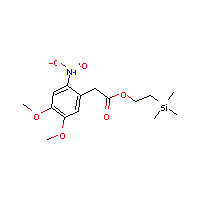

In [12]:
with_sime2[7000]

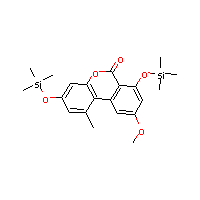

In [10]:
with_sime3[5234]

In [ ]:
tms = '[Si]([CH3])([CH3])[CH3]'

# XXX: ~[O,N,S] would match more than we aim to (-O, -S, -N, =N) but it's unlikely to happen
tms_match = Chem.MolFromSmarts('*~[O,N,S]' + tms)
tms_match0 = Chem.MolFromSmarts('[#0]([CH3])([CH3])[CH3]')

def is_derivatized(m):
    return m.HasSubstructMatch(tms_match)

def remove_derivatization_groups(m):
    em = deepcopy(m)
    matches = em.GetSubstructMatches(tms_match)
    for ma in matches:
        em.GetAtomWithIdx(ma[2]).SetAtomicNum(0)
    
    return AllChem.DeleteSubstructs(em,tms_match0)

_subs = [
 ('[OH]', [200], [.95]),
 ('[SH]', [201], [.80]),
# matches also imine
 ('[NH]', [202], [.50]),
 ('[NH2]', [203,202], [.25, .5]),  
]

_repls = {
    200: 'O'+tms,
    201: 'S'+tms,
    202: 'N'+tms,
    203: f'N({tms}){tms}',
}

subs=[]
for pat,repls,probs in _subs:
    spat = Chem.MolFromSmarts(pat)
    subs.append((spat,repls,probs))

repls = zip(
    map(lambda n: Chem.MolFromSmarts(f'[#{n}]'),_repls),
    map(Chem.MolFromSmiles,_repls.values())
)


def add_derivatization_groups(m):
    em = deepcopy(m)
    
    n = 200
    for pat,reps,probs in subs:
        matches = em.GetSubstructMatches(tms_match)
        for m in matches:
            r = random.random()
            r = 0
            for repl,prob in zip(reps,probs):
                if r < prob: 
                    em.GetAtomWithIdx(m[0]).SetAtomicNum(repl)
                    break
    
    for pat,repl in repls:
 #       print(pat,repl,em)
        em, = AllChem.ReplaceSubstructs(em,pat,repl)
        
    return em    

In [ ]:
#test_smi='CCO[Si](C)(C)C'
test_smi='C[Si](C)(C)OCC=N[Si](C)(C)C'
test_m = Chem.MolFromSmiles(test_smi)
Chem.AddHs(test_m)

In [ ]:
test_n = remove_derivatization_groups(test_m)
Chem.AddHs(test_n)

In [ ]:
add_derivatization_groups(test_n)

In [ ]:
repls

In [ ]:
print("# total:", len(mols))
#print("# derivatized:", sum(map(is_derivatized,mols.values())))

In [ ]:
noderiv = {}
for smi in mols.keys():
    if is_derivatized(mols[smi]):
        n = remove_derivatization_groups(mols[smi])
        noderiv[Chem.MolToSmiles(n)] = n
        print(smi,"=>", Chem.MolToSmiles(n))
    else:
        noderiv[smi] = mols[smi]

In [ ]:
m = Chem.MolFromSmiles('C=N')
m

In [ ]:
p = Chem.MolFromSmarts('*=N')

In [ ]:
m.HasSubstructMatch(p)

In [ ]:
(1,2,3)[:-1]

In [ ]:
a = Chem.MolFromSmiles('C[OH]')
a.GetAtomWithIdx(2).SetAtomicNum(2)

In [ ]:
Chem.MolToSmiles(Chem.AddHs(a))

In [ ]:
Chem.AddHs(a)

In [ ]:
subs